#Git pull & Julia environment setup

In [ ]:
!git clone https://github.com/Peregriney/baseball_batting.git

Cloning into 'baseball_batting'...
remote: Enumerating objects: 312, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 312 (delta 113), reused 164 (delta 106), pack-reused 136 (from 1)
Receiving objects: 100% (312/312), 621.15 KiB | 2.04 MiB/s, done.
Resolving deltas: 100% (177/177), done.


In [ ]:
%cd baseball_batting
!ls

/content/baseball_batting
agg-der.jl		dpsim-difference.png	  player.jl	   redsox_2023_lineuptop.csv
agg.jl			histogram-comparison.png  player-rbi.jl    redsox_avgs.csv
baseball_batting.ipynb	main.jl			  playertest.jl    runtime-hist.png
config.toml		mainv2.jl		  plotpmf.jl	   sabermetriccomparison.jl
demo.jl			nl.jl			  plotquantile.jl  sim.jl
derivatives.jl		pkgimport.jl		  redsox_2023.csv  sim-player.jl


Run to download Julia and necessary packages to runtime, then proceed with rest of code.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz
  export GKSwstype=100 ;

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2024-10-21 04:01:49 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.8

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


In [ ]:
!julia pkgimport.jl > install_log.txt 2>&1

In [ ]:
import pandas as pd
import pandas as pd
import unicodedata
import re
import subprocess

def fetch_batting_orders(team_abbr, year):
    # Construct the URL based on the team abbreviation and year == batting order
    url = f'https://www.baseball-reference.com/teams/{team_abbr}/{year}-batting-orders.shtml#grid_table_46565'

    try:
        # Read all tables from the page
        tables = pd.read_html(url)

        # Assuming the desired table is the first one
        df = tables[0]
        df.iloc[:, 1:] = df.iloc[:, 1:].map(lambda x: remove_non_alpha(normalize_string(x)))

        df.to_csv('br-lineups.csv', index=False)

        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


def fetch_player_stats(team_abbr, year):
    # Construct the URL based on the team abbreviation and year == batting order
    url = f'https://www.baseball-reference.com/teams/{team_abbr}/{year}.shtml#team_batting'

    try:
        # Read all tables from the page
        tables = pd.read_html(url)
        #print(tables)

        # Assuming the desired table is the first one
        df = tables[0]
        #print(df)
        df['Name'] = df['Name'].apply(lambda x: remove_non_alpha(normalize_string(x)))
#        df.drop([0],axis=0,inplace=True)
        df.drop(columns=['Rk', 'Pos', 'Age','G','PA','RBI','SB','CS','BA','OBP','SLG','OPS','OPS+','TB','GDP','HBP','SH','SF','IBB'],inplace=True)
        #print(df)
        df = df[~df['AB'].str.contains('[a-zA-Z]', na=False)]
        df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
        df = df[df['AB'] > 0]
        strikeout = pd.Series(df['SO']/df['AB'])
        hits = pd.Series(df['H']/df['AB'])
        doubles = pd.Series(df['2B']/df['AB'])
        triples = pd.Series(df['3B']/df['AB'])
        homer = pd.Series(df['HR']/df['AB'])
        singles = hits - doubles - triples - homer
        walks = pd.Series(df['BB']/df['AB'])
        otherout = 1 - walks - singles - homer - triples - doubles - strikeout
        #        df.drop(columns=['SO'], ['AB'], )
        df = df[['Name']]
        df['Strikeout'] = strikeout
        df['OO'] = otherout
        df['Walk'] = walks
        df['Single'] = singles
        df['Double'] = doubles
        df['Triple'] = triples
        df['Homer'] = homer
        df.to_csv('br-playerstats.csv', index=False)

        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


def normalize_string(s):
    """
    Normalize Unicode string by removing accents.
    """
    # Normalize to NFD form and remove accent marks
    return unicodedata.normalize('NFD', s).encode('ascii', 'ignore').decode('ascii')

def remove_non_alpha(s):
    """
    Remove all non-alphabetic characters from the string.
    """
    #return re.sub(r'[^a-zA-Z \-]', '', s)
    return re.sub(r'[^a-zA-Z\s-]', '', s)

def clean_names(series):
    """
    Clean the names in the pandas Series by normalizing and removing non-alphabetic characters.
    """
    # Apply normalization and removal of non-alphabetic characters
    cleaned_series = series.apply(lambda x: remove_non_alpha(normalize_string(x)))
    # Convert the cleaned Series to a list
    cleaned_list = cleaned_series.tolist()
    return cleaned_list

# Function to extract score from the first column
def extract_score(text):
    match = re.search(r'\((\d+)-(\d+)\)', text)
    if match:
        return int(match.group(1))  # Return the first number
    return None

# Function to get lineup indices based on player names
def get_lineup_indices(players_str, player_index):
    #players = players_str.split('\t')[1:]  # Skip the first element
    lineup_indices = []
    #print(players_str)
    for player in players_str:
        #last_name = player.split('-')[0].strip()  # Extract the last name
        last_name = player.rsplit('-',1)[0].strip().split(' ')[-1]
        # If the last name is found in the player_index mapping
        if last_name in player_index:
            lineup_indices.append(str(player_index[last_name]))

    #print(lineup_indices)
    return str(lineup_indices)#''.join(lineup_indices)#.ljust(9, player_index[last_name])  # Ensure it's a 9-number string


def process_output(stat_df,input_df):
      #player_list = clean_names(stat_df['Name'])
      player_list = stat_df['Name']
      #player_index = {name.split(' ')[1]: idx+1 for idx, name in enumerate(player_list)}

      player_index = {
          name.split(' ')[-2] if name.split(' ')[-1] in ["Jr","II","III","IV"] else name.split(' ')[-1]: idx + 1
          for idx, name in enumerate(player_list)
      }
      # Process the data
      output_data = []
      for _, row in input_df.iterrows():
          first_column = row[0]
          second_column = row[1:]
          score = extract_score(first_column)
          lineup_indices = get_lineup_indices(second_column, player_index)
          output_data.append([score, lineup_indices])

      # Create a DataFrame for the output
      output_df = pd.DataFrame(output_data, columns=['Score', 'Lineup'])

      # Save the output DataFrame to a new CSV file
      output_df.to_csv('output.csv', index=False)
      return


# Version 2

In [ ]:
team = 'ARI'
yr = 2023



input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)

#!julia main.jl br-playerstats.csv 1 2 3 4 5 6 7 8 9

<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


In [ ]:
!julia mainv2.jl br-playerstats.csv 1 2 3 4 5 6 7 8 9 ARI

accepted batting lineup[1, 2, 3, 4, 5, 6, 7, 8, 9]
[19, 3, 6, 2, 11, 14, 10, 1, 25]Processing lineup: '19', '3', '6', '2', '11', '14', '10', '1', '8'
[4.212876935582244, 6.5241099977947e-310, 6.52412571061344e-310, 6.5241256357961e-310, 6.52412563697237e-310, 6.5241256357961e-310, 6.5241099977963e-310, 6.52412571061344e-310, 6.5241256357961e-310, 6.5241256372127e-310, 6.5241256357961e-310, 6.5241258428507e-310, 6.52412573333177e-310, 6.5241258428507e-310, 6.52412571083874e-310, 6.5241259097488e-310, 6.52413568280914e-310, 6.5241257106324e-310, 6.5241257106324e-310, 6.52412591769177e-310, 6.52412563692573e-310, 6.52412571083874e-310, 6.52412571061344e-310, 6.5241257106324e-310, 6.52412571061344e-310, 6.52412571061344e-310, 6.5241256357961e-310, 6.5241256357961e-310, 6.52412571061344e-310, 6.5241256357961e-310, 6.52412591769177e-310, 6.52412563692573e-310, 6.52412571083874e-310, 6.52412571061344e-310, 6.5241256357961e-310, 6.5241256357961e-310, 6.52412571061344e-310, 6.5241256357961e-310

In [ ]:
teams = ['ATL', 'BAL','BOS', 'CHC','CHW','CIN','CLE','COL','DET','HOU',
         'HOU','KCR','LAA','LAD','MIA','MIL','MIN','NYM','NYY','OAK','PHI',
         'PIT','SDP','SEA','SFG','STL','TBR','TEX','TOR','WSN'
         ]

yr = 2023


for team in teams:
  print(team)

  input_df = fetch_batting_orders(team,yr)
  stat_df = fetch_player_stats(team,yr)
  process_output(stat_df,input_df)
  input_file = 'br-playerstats.csv'
  columns_str = '1 2 3 4 5 6 7 8 9'
  command = f"julia mainv2.jl {input_file} {columns_str} {team}"
  result = subprocess.run(command, shell=True, check=True, text=True, capture_output=True)
  #!julia mainv2.jl br-playerstats.csv 1 2 3 4 5 6 7 8 9 team


BAL


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


BOS


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


CHC


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


CHW


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


CIN


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


CLE


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


COL


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


DET


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


HOU


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


HOU


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


KCR


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


LAA


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


LAD


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


MIA


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


MIL


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


MIN


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


NYM


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


NYY


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


OAK


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


PHI


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


PIT


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


SDP


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


SEA


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


SFG


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


STL


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


TBR


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


TEX


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


TOR


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


WSN


<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


In [ ]:
!julia mainv2.jl br-playerstats.csv 1 2 3 4 5 6 7 8 9 ARI

accepted batting lineup[1, 2, 3, 4, 5, 6, 7, 8, 9]
['19', '3', '6', '2', '11', '14', '10', '1', '8']
[19, 3, 6, 2, 11, 14, 10, 1, 25]Processing lineup: '19', '3', '6', '2', '11', '14', '10', '1', '8'
[4.212876935582244, 6.8413802382477e-310, 6.8413802382493e-310, 6.8413802384074e-310, 6.8413995749763e-310, 6.8414061833952e-310, 6.84138023825086e-310, 6.84138023825244e-310, 6.84138023840896e-310, 6.841380238254e-310, 6.8414060351795e-310, 6.8413802377086e-310, 6.8413802382556e-310, 6.84138023771016e-310, 6.8413802382572e-310, 6.84139985158587e-310, 6.84138023825877e-310, 6.84138023826035e-310, 6.84138023826193e-310, 6.8413994494591e-310, 6.8413802382635e-310, 6.8413802382651e-310, 6.84138023826667e-310, 6.84138023826825e-310, 6.84138023826983e-310, 6.8413802382714e-310, 6.84138023841054e-310, 6.84138023841212e-310, 6.841380238273e-310, 6.8413802384137e-310, 6.8413994494591e-310, 6.84138023827616e-310, 6.84138023827774e-310, 6.8413802382793e-310, 6.8414061833976e-310, 6.8414061833984e-31

# Analysis on V2

When calculating the possible game outcomes with DP, we only consider one subset of 9 players (where 8 are real players, chosen rom the first game of season), and the 9th is a synthetic player meant to bring the 9-player batting lineup to the team season average.

However, this ordering is likely not optimal. When comparing the mean of all empirical scores on real-world games, vs. the mean of DP expected score computed on all real-world games, we find that DP and empirical have low MAE.

Below is another example (ATL 2023)

In [ ]:
#display(wsn_dp.iloc[:,2:].rename(columns={2:'DP_mean', 3:'RunOutcomes', 4:'ProbOutcomes', 5: 'Team'}))

In [ ]:
team = 'ATL'
yr = 2023

input_df = fetch_batting_orders(team,yr)
stat_df = fetch_player_stats(team,yr)
process_output(stat_df,input_df)

<ipython-input-5-9d2ccdf79b1e>:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_column = row[0]


ATL


Text(0.5, 1.0, 'ATL 2023')

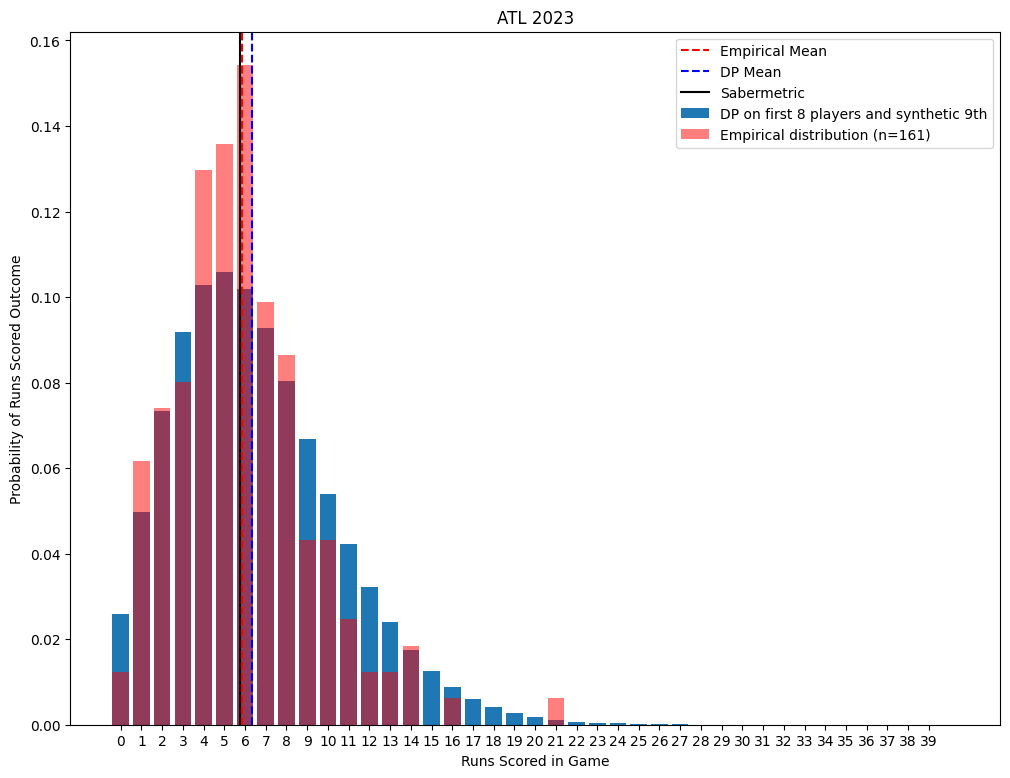

In [ ]:
wsn_empirical = pd.read_csv('output.csv')['Score'][:-2]

wsn_dp = pd.read_csv('v2_probs.csv',header=None)
print(wsn_dp.iloc[0,5])

list_column_3 = wsn_dp.iloc[0, 3].split(',')  # First row, first column
list_column_4 = wsn_dp.iloc[0, 4].split(',')  # First row, second column
dp = float(wsn_dp.iloc[0,2])

list_column_3 = [int(num) for num in list_column_3]
list_column_4 = [float(num) for num in list_column_4]
plt.figure(figsize=(12,9))
plt.bar(list_column_3, list_column_4,label='DP on first 8 players and synthetic 9th')
#plt.hist(wsn_empirical, bins = int(wsn_empirical.max()), weights=np.ones(len(wsn_empirical)) / len(wsn_empirical),color='red',alpha=.5,label='Empirical distribution (n=161)')

x_positions = np.arange(0, 40)
values, counts = np.unique(wsn_empirical, return_counts=True)
percentages = counts / len(wsn_empirical)
bar_counts = np.zeros(len(x_positions))
bar_counts[values.astype(int)] = percentages

plt.bar(x_positions, bar_counts, color='red', alpha=0.5, label='Empirical distribution (n=161)')
plt.xticks(x_positions)


plt.axvline(wsn_empirical.mean(), color = 'red', ls='--',label='Empirical Mean')
plt.axvline(dp, color = 'blue', ls='--', label='DP Mean')
plt.axvline(5.732590, color = 'black', ls = '-', label='Sabermetric')

plt.legend()
plt.xlabel('Runs Scored in Game')
plt.ylabel('Probability of Runs Scored Outcome')
plt.title(team + ' 2023')


In [ ]:
df = pd.DataFrame({'DP': list_column_4[:40], 'Empirical': bar_counts})
df['Error'] = abs(df['Empirical'] - df['DP'])
pd.options.display.float_format = '{:20,.6f}'.format
print('Proportion of games ending with different runs scored for DP vs. Empirical Distributions')
display(df)

Proportion of games ending with different runs scored for DP vs. Empirical Distributions


,DP,Empirical,Error
0,0.025878,0.012346,0.013533
1,0.049643,0.061728,0.012085
2,0.073281,0.074074,0.000793
3,0.091892,0.080247,0.011645
4,0.102904,0.129630,0.026725
5,0.105920,0.135802,0.029883
6,0.101946,0.154321,0.052375
7,0.092724,0.098765,0.006041
8,0.080392,0.086420,0.006028
9,0.066920,0.043210,0.023710


# Main Code: 2023 Red Sox batting avgs


In [ ]:
!julia main.jl redsox_2023.csv 4 7 3 2 9 1 8 5 6

Player batting probabilities all sum to 1
accepted batting lineup[4, 7, 3, 2, 9, 1, 8, 5, 6]
populating memo
  0.515292 seconds (913.75 k allocations: 45.446 MiB, 92.77% compilation time)
calculating expected runs
p(0) is 0.06335467282283026
p(1) is 0.09492857084728976
p(2) is 0.11776186497140737
p(3) is 0.12603903440538347
p(4) is 0.121749016406277
p(5) is 0.10939608609076235
p(6) is 0.09283852881568241
p(7) is 0.07501205566147555
p(8) is 0.05812921003438619
p(9) is 0.04340392478136401
p(10) is 0.03139013208792811
p(11) is 0.022089685505928026
p(12) is 0.01519095981800549
p(13) is 0.010241139936626939
p(14) is 0.006778697612757728
p(15) is 0.004407144678288749
p(16) is 0.00281384742333539
p(17) is 0.0017647239663086726
p(18) is 0.0010883495655138965
p(19) is 0.0006614055889739304
p(20) is 0.00039708543914248625
p(21) is 0.00023602863778220148
p(22) is 0.0001390597507922986
p(23) is 8.118968619189076e-5
p(24) is 4.692063610467783e-5
p(25) is 2.6806870088727633e-5
p(26) is 1.51328004342

In [ ]:
!julia plotpmf.jl

Expected Number (Mean): 4.841375056924311


In [ ]:
!julia plotquantile.jl

maxR = 40 by default


Plots

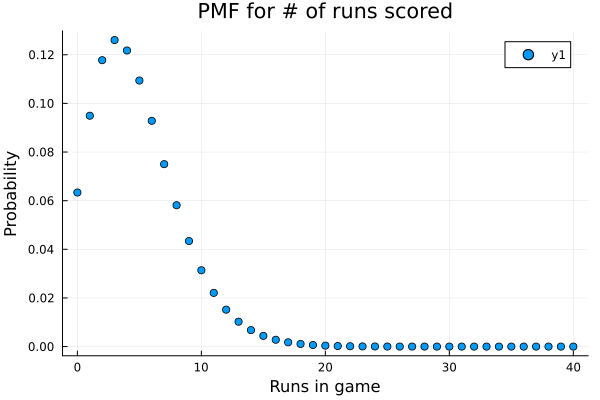

In [ ]:
from IPython.display import Image
Image(filename='pmf.png')


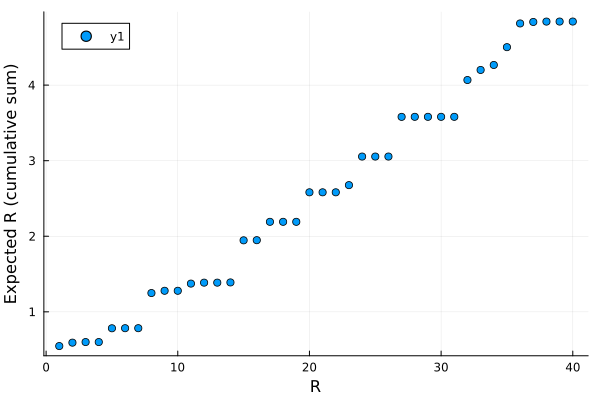

In [ ]:
from IPython.display import Image
Image(filename='quantile.png')


In [ ]:
!julia sim.jl redsox_2023.csv 1000000 4 7 3 2 9 1 8 5 6

Accepted batting lineup [4, 7, 3, 2, 9, 1, 8, 5, 6]
Comparison of DP vs. Simulated Summary Stats:
4×3 DataFrame
 Row │ Metric                  DP        Simulated 
     │ String                  Float64   Float64   
─────┼─────────────────────────────────────────────
   1 │ Expected Number (Mean)   4.84138    4.82632
   2 │ Standard Deviation       3.39297    3.39091
   3 │ Minimum                  0.0        0.0
   4 │ Maximum                 40.0       35.0

Comparison of DP vs. Simulated histograms:
4×2 DataFrame
 Row │ Metric       Value      
     │ String       Float64    
─────┼─────────────────────────
   1 │ Sum abs dif  0.00383621
   2 │ Sum sq dif   1.65474e-6
   3 │ Corr         0.999987
   4 │ Chi-square   3.84919e-5

Table of difference in Pr(r) (%) for DP - sim
32×2 DataFrame
 Row │ R      Difference   
     │ Int64  Float64      
─────┼─────────────────────
   1 │     0  -0.0799327
   2 │     1  -0.0377429
   3 │     2  -0.0700135
   4 │     3  -0.000796559
   5 │     4

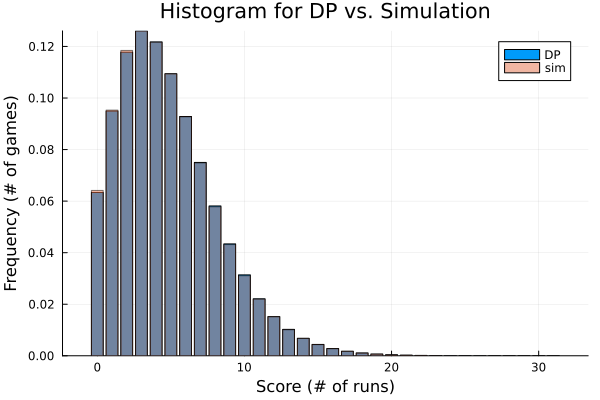

In [ ]:
from IPython.display import Image
Image(filename='histogram-comparison.png')


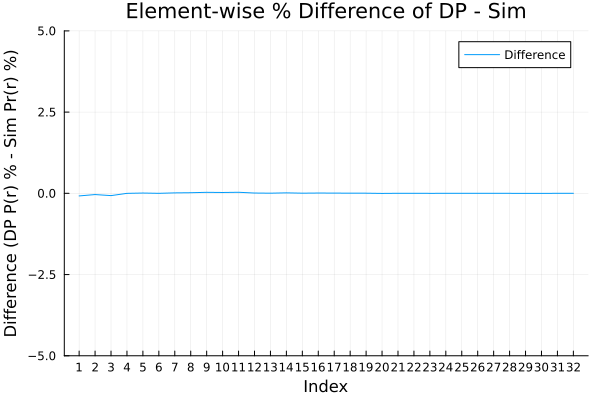

In [ ]:
from IPython.display import Image
Image(filename='dpsim-difference.png')
